In [1]:
import numpy as np
import pymust # To install it, use pip -e . install, orcopy the src/pymust folder to your project
import pymust.utils
import matplotlib.pyplot as plt
import scipy, scipy.io
import matplotlib, tqdm, tqdm.notebook, time


In [2]:
from line_profiler import LineProfiler
debug_line = False

# Test disk 
Here I generate a rotating disk, I test simus, txdelay, dasmtx, rf2iq and bmode

In [3]:
def rotatePoints(x, y, x0, y0, theta):
    """
    Rotate points (x,y) around (x0,y0) by theta radians
    """
    x = x - x0
    y = y - y0
    x1 = x * np.cos(theta) - y * np.sin(theta) + x0
    y1 = x * np.sin(theta) + y * np.cos(theta) + y0
    return x1, y1

In [4]:
param = pymust.getparam('P4-2v')
nPoints = 200000
xs = np.random.rand(1,nPoints)*12e-2-6e-2
zs = np.random.rand(1,nPoints)*12e-2

centerDisk = 0.05
idx = np.hypot(xs,zs-centerDisk)<2e-2 # First disk
idx2 = np.hypot(xs,zs-.035)< 5e-3 # Second disk

RC = np.random.rand(*xs.shape)  # reflection coefficients

# Add reflectiion to both spheres
RC[idx] += 1
RC[idx2] += 2


# Rotating disk velocity
rotation_frequency = .5
w = 2 * np.pi  * rotation_frequency#1 Hz = 2 pi rads
nreps = 5
param.PRP = 1e-3

In [5]:
if debug_line:
    lp = LineProfiler()
    lp.add_function(pymust.pfield)
    pymust.simus = lp(pymust.simus)

In [6]:
t = time.time()
for i in tqdm.tqdm(range(nreps)):
    options = pymust.utils.Options()
    options.ParPoolMode = 'process'
    options.ParPool_NumWorkers = 12
    options.dBThresh = -6
    options.ParPool = True

    xs[idx], zs[idx] = rotatePoints(xs[idx], zs[idx], 0, centerDisk,  w *  param.PRP)
    width = 60/180*np.pi; # width angle in rad
    txdel = pymust.txdelay(param,0,width) # in s
    RF, RF_spectrum = pymust.simus(xs,zs,RC,txdel,param, options)
    if i ==0:
        IQ = np.zeros([RF.shape[0], RF.shape[1], nreps], dtype = np.complex128)
    IQ[:, :, i] = pymust.rf2iq(RF,param)
print('elapsed time = ', time.time() - t)

100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

elapsed time =  5.150323867797852


In [7]:
if debug_line:
    lp.print_stats()
    lp.dump_stats('rotatingDiskVelocitySynthetic.lprof')

Timer unit: 1e-09 s

Total time: 5.03752 s
File: /Users/gbernardino/pymust/src/pymust/pfield.py
Function: pfield at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def pfield(x : np.ndarray,y : np.ndarray, z: np.ndarray, delaysTX : np.ndarray, param: utils.Param, isQuick : bool = False, options : utils.Options = None):
    10                                           #PFIELD   RMS acoustic pressure field of a linear or convex array
    11                                           #   RP = PFIELD(X,Y,Z,DELAYS,PARAM) returns the radiation pattern of a
    12                                           #   uniform LINEAR or CONVEX array whose elements are excited at different
    13                                           #   time delays (given by the vector DELAYS). The radiation pattern RP is
    14                                           #   given in terms of the root-mean-square (RMS) of acoustic pressure. The
 

In [8]:
x,z = pymust.impolgrid(np.array([256, 256]),
                          10e-2, 
                          np.pi/3,
                          param)
Mdas = pymust.dasmtx(IQ[:,:,0],x,z,param)
IQb = np.zeros((x.shape[0], x.shape[1], nreps), dtype = np.complex128)
for i in tqdm.notebook.tqdm(range(nreps)):
    IQb[:, :, i] = (Mdas@IQ[:,:,i].flatten(order = 'F')).reshape(x.shape, order = 'F')


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_6625/2099971117.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')


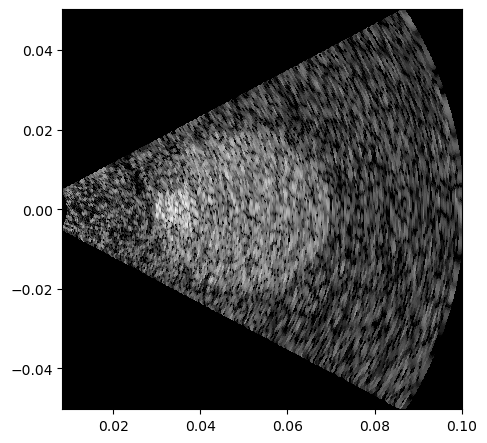

In [9]:
b = pymust.bmode(IQb[:,:,0])
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.15,0.15,0.8,0.8])
#fig.set_facecolor("black")
ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
plt.savefig('carte_polar.png')


In [10]:
doppler_vel, doppler_var = pymust.iq2doppler(IQb,param)
VN = pymust.getNyquistVelocity(param)

/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_6625/998413440.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_6625/998413440.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm = plt.pcolormesh(z, x , doppler_vel,edgecolors='face', cmap = pymust.getDopplerColorMap().cmap, alpha = doppler_var/np.max(doppler_var), vmin = -VN, vmax = VN)


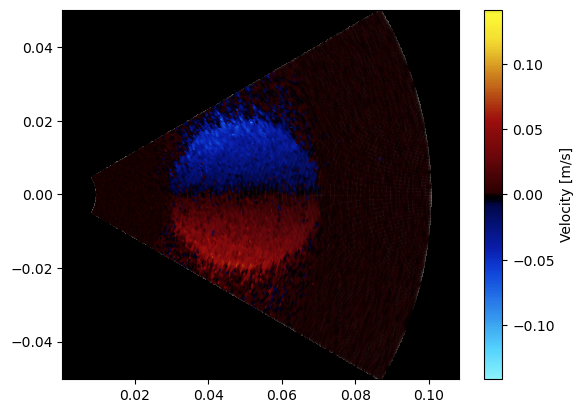

In [11]:
#fig = plt.figure(figsize=[5,5])
#ax = fig.add_axes([0.15,0.15,0.8,0.8])
#fig.set_facecolor("black")
plt.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
plt.axis('equal')

cm = plt.pcolormesh(z, x , doppler_vel,edgecolors='face', cmap = pymust.getDopplerColorMap().cmap, alpha = doppler_var/np.max(doppler_var), vmin = -VN, vmax = VN)
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
cbar = plt.colorbar(cm)
cbar.ax.set_ylabel('Velocity [m/s]')
ax = plt.gca()
ax.set_facecolor('black')

plt.savefig('carte_polar.png')


/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_6625/4283511898.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_6625/4283511898.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm = ax.pcolormesh(z, x , doppler_var,edgecolors='face', cmap = pymust.getDopplerColorMap().cmap, )


Text(0.5, 1.0, 'Doppler variance')

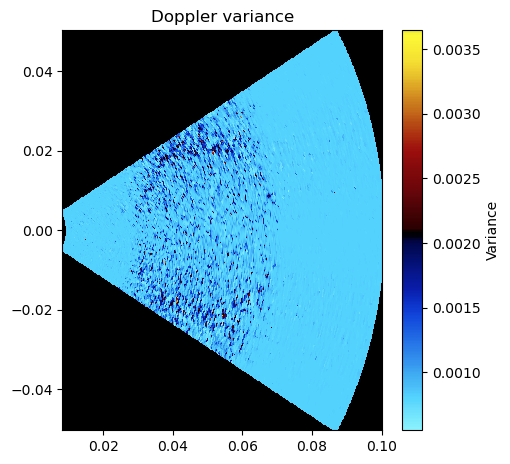

In [12]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.15,0.15,0.8,0.8])
#fig.set_facecolor("black")
ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')

cm = ax.pcolormesh(z, x , doppler_var,edgecolors='face', cmap = pymust.getDopplerColorMap().cmap, )
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
cbar = plt.colorbar(cm)
cbar.ax.set_ylabel('Variance')
plt.title('Doppler variance')
#plt.savefig('carte_polar.png')
